In [1]:
!pip install pandas matplotlib  fsspec s3fs intake 

In [2]:
import intake
import pandas as pd
import numpy as np
from scipy.signal import stft
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

plt.rcParams["font.family"] = "sans"
plt.rcParams["font.size"] = 8

# Data Gallery

This notebook contains example plots of data from different diagnostics as a demonstration of what sort data is available in the archive. 

First we need to find the url to a particular shot. Here we are going to use shot 30420 as an example.

In [3]:
shot_id = 30420
catalog  = intake.from_yaml_file("https://mastapp.site/intake/catalog.yml")
shot_df = pd.DataFrame(catalog.index.level1.shots().read())
url = shot_df.loc[shot_df.shot_id == shot_id].iloc[0].url

FileNotFoundError: https://mastapp.site/intake/catalog.yml

## Plasma Current Data

Data from the `amc` source contains
 - Plasma Current ($I_p$): Flows within the plasma, providing initial heating and contributing to the poloidal magnetic field for confinement and stability.
 - PF Coil Currents: Control the poloidal magnetic field, allowing for plasma shaping, vertical stability, and edge magnetic configuration control.
 - TF Coil Currents: Generate the strong toroidal magnetic field necessary for primary plasma confinement.

In [59]:
level1_catalog = catalog.level1.read()
dataset = level1_catalog(urlpath=url, group='amc').shots.read()

dataset

/opt/homebrew/anaconda3/lib/python3.12/site-packages/zarr/storage/_fsspec.py:195: UserWarning: fs (<fsspec.implementations.cached.SimpleCacheFileSystem object at 0x30e2af320>) was not created with `asynchronous=True`, this may lead to surprising behavior
  return cls(fs=fs, path=path, read_only=read_only, allowed_exceptions=allowed_exceptions)


<xarray.Dataset> Size: 5MB
Dimensions:            (time: 30000)
Coordinates:
  * time               (time) float32 120kB -2.0 -2.0 -2.0 ... 3.999 4.0 4.0
Data variables: (12/46)
    efps_current       (time) float32 120kB dask.array<chunksize=(30000,), meta=np.ndarray>
    error_field_02     (time) float32 120kB dask.array<chunksize=(30000,), meta=np.ndarray>
    error_field_05     (time) float32 120kB dask.array<chunksize=(30000,), meta=np.ndarray>
    p2il_coil_current  (time) float32 120kB dask.array<chunksize=(30000,), meta=np.ndarray>
    p2il_feed_current  (time) float32 120kB dask.array<chunksize=(30000,), meta=np.ndarray>
    p2iu_coil_current  (time) float32 120kB dask.array<chunksize=(30000,), meta=np.ndarray>
    ...                 ...
    p6u_current        (time) float32 120kB dask.array<chunksize=(30000,), meta=np.ndarray>
    plasma_current     (time) float32 120kB dask.array<chunksize=(30000,), meta=np.ndarray>
    sol_current        (time) float32 120kB dask.array<chunksize=(30000,), meta=np.ndarray>
    status             float32 4B ...
    tf_current         (time) float32 120kB dask.array<chunksize=(30000,), meta=np.ndarray>
    version            float32 4B ...
Attributes:
    description:  Plasma Current and PF/TF Coil Currents
    file_name:    amc0304.20
    format:       IDA3
    mds_name:     None
    name:         amc
    quality:      Not Checked
    shot_id:      30420
    signal_type:  Analysed
    source:       amc
    uda_name:     AMC
    uuid:         01aad0c4-2a84-59e2-8b1b-168b4bd66aa3
    version:      0

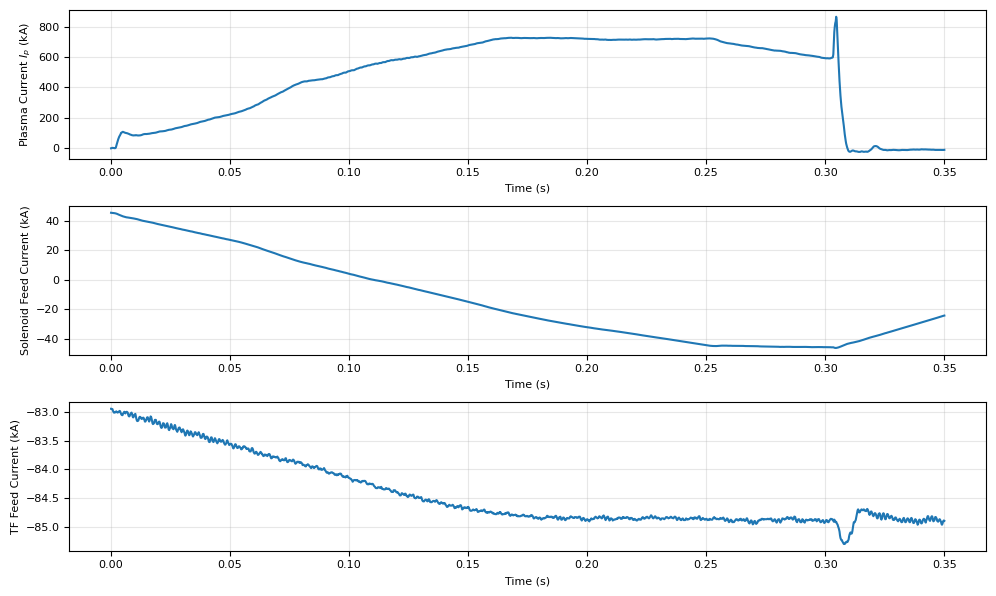

In [60]:
dataset = dataset.isel(time=(dataset.time > 0) & (dataset.time < .35))
fig, axes = plt.subplots(3, 1, figsize=(10, 6))
ax1, ax2, ax3 = axes.flatten()

ax1.plot(dataset['time'], dataset['plasma_current'])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Plasma Current $I_p$ (kA)')

ax2.plot(dataset['time'], dataset['sol_current'])
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Solenoid Feed Current (kA)')

ax3.plot(dataset['time'], dataset['tf_current'])
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('TF Feed Current (kA)')

for ax in axes:
    ax.grid(alpha=0.3)

plt.tight_layout()

## Thompson Scattering Data

`ayc` source holds the Thomspon Scattering data at the core. Thomson scattering diagnostics provide accurate measurements of electron temperature and density.

In [64]:
dataset = level1_catalog(urlpath=url, group='ayc')
dataset = dataset.shots.read()

dataset

/opt/homebrew/anaconda3/lib/python3.12/site-packages/zarr/storage/_fsspec.py:195: UserWarning: fs (<fsspec.implementations.cached.SimpleCacheFileSystem object at 0x31b5d0ef0>) was not created with `asynchronous=True`, this may lead to surprising behavior
  return cls(fs=fs, path=path, read_only=read_only, allowed_exceptions=allowed_exceptions)


<xarray.Dataset> Size: 1MB
Dimensions:              (acqiris_time: 73, radial_index: 131, arb: 130,
                          time: 73, spectral_index: 4, instrument_time: 20,
                          time_segment: 73, xyc_time: 73)
Coordinates:
  * acqiris_time         (acqiris_time) float32 292B 0.0 1.0 2.0 ... 71.0 72.0
  * arb                  (arb) float32 520B 0.0 1.0 2.0 ... 127.0 128.0 129.0
  * instrument_time      (instrument_time) float32 80B 1.0 2.0 3.0 ... 19.0 20.0
  * radial_index         (radial_index) float32 524B 0.0 1.0 2.0 ... 129.0 130.0
  * spectral_index       (spectral_index) float32 16B 1.0 2.0 3.0 4.0
  * time                 (time) float32 292B 0.004166 0.008332 ... 0.3 0.3042
  * xyc_time             (xyc_time) float32 292B 0.0 1.0 2.0 ... 70.0 71.0 72.0
Dimensions without coordinates: time_segment
Data variables: (12/36)
    acqiris_time_        (acqiris_time) float32 292B dask.array<chunksize=(73,), meta=np.ndarray>
    angle                (radial_index) float32 524B dask.array<chunksize=(131,), meta=np.ndarray>
    aspectra             (time, radial_index, spectral_index) float32 153kB dask.array<chunksize=(73, 131, 4), meta=np.ndarray>
    chi2                 (time, radial_index) float32 38kB dask.array<chunksize=(73, 131), meta=np.ndarray>
    covariance_ne_te     (time, radial_index) float32 38kB dask.array<chunksize=(73, 131), meta=np.ndarray>
    instrument_dr        (instrument_time, radial_index) float32 10kB dask.array<chunksize=(20, 131), meta=np.ndarray>
    ...                   ...
    te_error             (time, radial_index) float32 38kB dask.array<chunksize=(73, 131), meta=np.ndarray>
    version_fibre        float32 4B ...
    version_poly         float32 4B ...
    version_raman        float32 4B ...
    xyc_time_            (xyc_time) float32 292B dask.array<chunksize=(73,), meta=np.ndarray>
    yag_nelint           (time) float32 292B dask.array<chunksize=(73,), meta=np.ndarray>
Attributes:
    description:  Core Thomson scattering data
    file_name:    ayc0304.20
    format:       IDA3
    mds_name:     None
    name:         ayc
    quality:      Not Checked
    shot_id:      30420
    signal_type:  Analysed
    source:       ayc
    uda_name:     AYC
    uuid:         8d043ece-8bf8-5af8-87e4-d2a1b01716fa
    version:      0

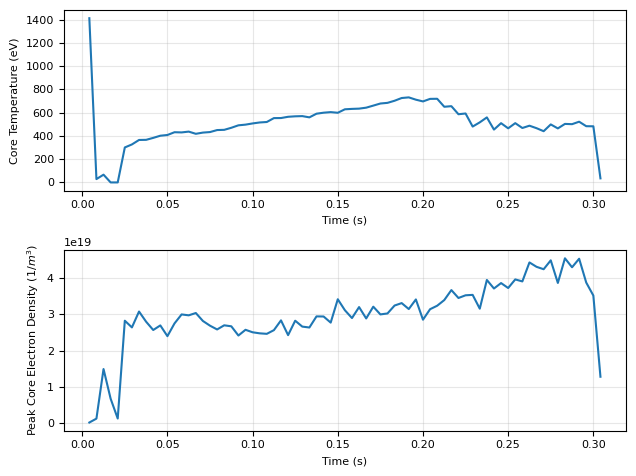

In [65]:
fig, axes = plt.subplots(2,1)
ax1, ax2 = axes

ax1.plot(dataset['time'], dataset['te_core'])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Core Temperature (eV)')

ax2.plot(dataset['time'], dataset['ne_core'])
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Peak Core Electron Density ($1 / m^3$)')

for ax in axes:
    ax.grid(alpha=0.3)

plt.tight_layout()

## CO2 Interferometers

CO2 interferometers (`ane`) are used to measure the electron density in the plasma. By measuring the phase shift of the laser beam as it passes through the plasma, the electron density can be inferred with high precision.

In [67]:
dataset = level1_catalog(urlpath=url, group='ane')
dataset = dataset.shots.read()

dataset

/opt/homebrew/anaconda3/lib/python3.12/site-packages/zarr/storage/_fsspec.py:195: UserWarning: fs (<fsspec.implementations.cached.SimpleCacheFileSystem object at 0x31b8d3d70>) was not created with `asynchronous=True`, this may lead to surprising behavior
  return cls(fs=fs, path=path, read_only=read_only, allowed_exceptions=allowed_exceptions)


<xarray.Dataset> Size: 524kB
Dimensions:        (time: 32768)
Coordinates:
  * time           (time) float32 131kB -0.01 -0.00996 -0.00992 ... 1.301 1.301
Data variables:
    co2            (time) float32 131kB dask.array<chunksize=(32768,), meta=np.ndarray>
    density        (time) float32 131kB dask.array<chunksize=(32768,), meta=np.ndarray>
    hene           (time) float32 131kB dask.array<chunksize=(32768,), meta=np.ndarray>
    passnumber     float32 4B ...
    status         float32 4B ...
    status_detail  float32 4B ...
    version        float32 4B ...
Attributes:
    description:  CO2 Interferometry
    file_name:    ane0304.20
    format:       IDA3
    mds_name:     None
    name:         ane
    quality:      Not Checked
    shot_id:      30420
    signal_type:  Analysed
    source:       ane
    uda_name:     ANE
    uuid:         5f814dd8-7336-56d7-a1ea-bac62e5cdcd3
    version:      0

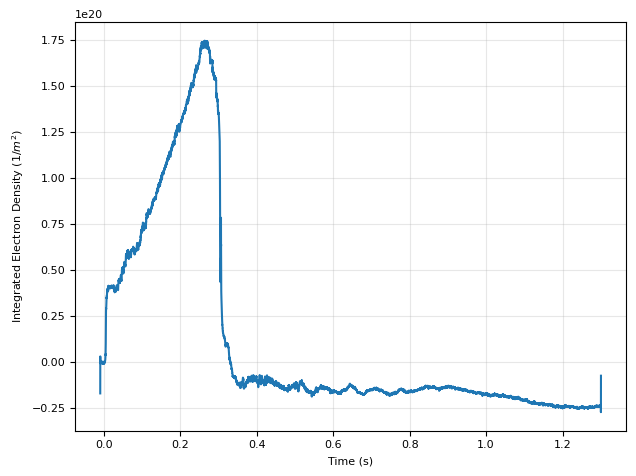

In [68]:
fig, ax = plt.subplots(1, 1)
plt.plot(dataset['time'], dataset['density'])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Integrated Electron Density ($1 / m^2$)')
ax.grid(alpha=0.3)

plt.tight_layout()

## Equillibrium Reconstruction Data

The source `efm` contains data from EFIT. EFIT is a computational tool used to reconstruct the magnetic equilibrium configuration of the plasma in a tokamak. It calculates the shape and position of the plasma, as well as the distribution of the current and pressure within it, based on magnetic measurements.


In [69]:
dataset = level1_catalog(urlpath=url, group='efm')
dataset = dataset.shots.read()
dataset

/opt/homebrew/anaconda3/lib/python3.12/site-packages/zarr/storage/_fsspec.py:195: UserWarning: fs (<fsspec.implementations.cached.SimpleCacheFileSystem object at 0x160097560>) was not created with `asynchronous=True`, this may lead to surprising behavior
  return cls(fs=fs, path=path, read_only=read_only, allowed_exceptions=allowed_exceptions)


<xarray.Dataset> Size: 4MB
Dimensions:            (time: 64, psi_norm: 65, n_iterations: 10,
                        fcoil_seg_n: 938, fcoil_n: 101, ffprime_coefs_n: 2,
                        mag_probe_n: 78, psi_loop_n: 46, r: 65, z: 65,
                        profile_r: 129, lcfs_coords: 147, limiter_n: 37,
                        pprime_coefs_n: 2, profile_z: 65)
Coordinates: (12/13)
  * fcoil_n            (fcoil_n) float32 404B 0.0 1.0 2.0 ... 98.0 99.0 100.0
  * ffprime_coefs_n    (ffprime_coefs_n) float32 8B 0.0 1.0
  * lcfs_coords        (lcfs_coords) float32 588B 0.0 1.0 2.0 ... 145.0 146.0
  * mag_probe_n        (mag_probe_n) float32 312B 0.0 1.0 2.0 ... 75.0 76.0 77.0
  * n_iterations       (n_iterations) float32 40B 0.0 1.0 2.0 ... 7.0 8.0 9.0
  * pprime_coefs_n     (pprime_coefs_n) float32 8B 0.0 1.0
    ...                 ...
  * profile_z          (profile_z) float32 260B -2.0 -1.938 -1.875 ... 1.938 2.0
  * psi_loop_n         (psi_loop_n) float32 184B 0.0 1.0 2.0 ... 43.0 44.0 45.0
  * psi_norm           (psi_norm) float32 260B 0.0 0.01562 ... 0.9844 1.0
  * r                  (r) float32 260B 0.06 0.09031 0.1206 ... 1.939 1.97 2.0
  * time               (time) float32 256B -0.05 -0.045 -0.04 ... 0.29 0.295 0.3
  * z                  (z) float32 260B -2.0 -1.938 -1.875 ... 1.875 1.938 2.0
Dimensions without coordinates: fcoil_seg_n, limiter_n
Data variables: (12/151)
    all_times          (time) float32 256B dask.array<chunksize=(64,), meta=np.ndarray>
    areap_c            (time, psi_norm) float32 17kB dask.array<chunksize=(64, 65), meta=np.ndarray>
    betan              (time) float32 256B dask.array<chunksize=(64,), meta=np.ndarray>
    betap              (time) float32 256B dask.array<chunksize=(64,), meta=np.ndarray>
    betapd             (time) float32 256B dask.array<chunksize=(64,), meta=np.ndarray>
    betat              (time) float32 256B dask.array<chunksize=(64,), meta=np.ndarray>
    ...                 ...
    wpol               (time) float32 256B dask.array<chunksize=(64,), meta=np.ndarray>
    xpoint1_rc         (time) float32 256B dask.array<chunksize=(64,), meta=np.ndarray>
    xpoint1_zc         (time) float32 256B dask.array<chunksize=(64,), meta=np.ndarray>
    xpoint2_rc         (time) float32 256B dask.array<chunksize=(64,), meta=np.ndarray>
    xpoint2_zc         (time) float32 256B dask.array<chunksize=(64,), meta=np.ndarray>
    zbdry              (time) float32 256B dask.array<chunksize=(64,), meta=np.ndarray>
Attributes:
    description:  Basic EFIT
    file_name:    efm0304.20
    format:       IDA3
    mds_name:     None
    name:         efm
    quality:      Not Checked
    shot_id:      30420
    signal_type:  Analysed
    source:       efm
    uda_name:     EFM
    uuid:         1e39c600-8ffb-5f56-900d-2941e352319c
    version:      0

Below we show how to load and plot the plasma current denisty and with the last closed flux surface (LCFS).

/var/folders/nm/_cbjksw57lq1_xxxvjhcsr1w0000gp/T/ipykernel_98195/1992647380.py:28: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contourf(R, Z, d[index], cmap='magma', levels=20, label='Plasma Current')


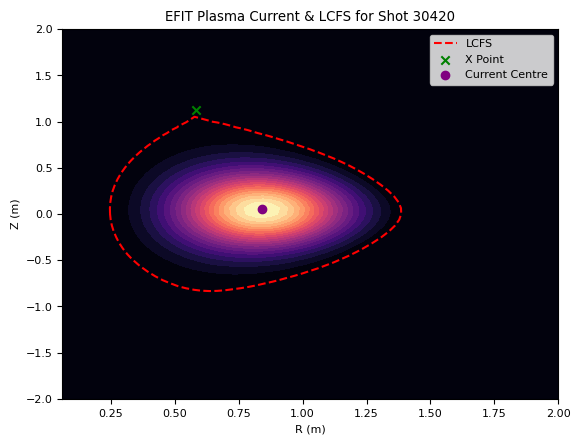

In [70]:
d = dataset['plasma_current_rz'].dropna(dim='time')
r = dataset['r']
z = dataset['z']


lcfs_R = dataset['lcfs_r'].sel(time=d.time)
lcfs_Z = dataset['lcfs_z'].sel(time=d.time)

R, Z = np.meshgrid(r, z)

index = 50

# Get the x-point
xpoint_r = dataset['xpoint2_rc'][index]
xpoint_z = dataset['xpoint2_zc'][index]

# Get the current centre
mag_axis_r = dataset['current_centrd_r'][index]
mag_axis_z = dataset['current_centrd_z'][index]

# Get the last closed flux surface (LCFS)
lcfs_r = lcfs_R[index].values
lcfs_r = lcfs_r[~np.isnan(lcfs_r)]
lcfs_z = lcfs_Z[index].values
lcfs_z = lcfs_z[~np.isnan(lcfs_z)]

fig, ax = plt.subplots()
ax.contourf(R, Z, d[index], cmap='magma', levels=20, label='Plasma Current')
ax.plot(lcfs_r, lcfs_z, c='red', linestyle='--', label='LCFS')
ax.scatter(xpoint_r, xpoint_z, marker='x', color='green', label='X Point')
ax.scatter(mag_axis_r, mag_axis_z, marker='o', color='purple', label='Current Centre')

plt.title(f'EFIT Plasma Current & LCFS for Shot {d.attrs["shot_id"]}')
plt.ylabel('Z (m)')
plt.xlabel('R (m)')
plt.legend()

## Mirnov Coils

Mirnov coils are primarily used to measure magnetic fluctuations in the plasma. These fluctuations can provide important information about various plasma instabilities. 

They are particularly useful for studying magnetohydrodynamic (MHD) phenomena. MHD activity includes various modes of instabilities, such as kink modes and tearing modes, which can affect plasma confinement and stability.

In [72]:
dataset = level1_catalog(urlpath='s3://mast/level1/shots/29790.zarr', group='xmo')
dataset = dataset.shots.read()
dataset

/opt/homebrew/anaconda3/lib/python3.12/site-packages/zarr/storage/_fsspec.py:195: UserWarning: fs (<fsspec.implementations.cached.SimpleCacheFileSystem object at 0x160a6abd0>) was not created with `asynchronous=True`, this may lead to surprising behavior
  return cls(fs=fs, path=path, read_only=read_only, allowed_exceptions=allowed_exceptions)


<xarray.Dataset> Size: 101MB
Dimensions:                        (dim_0: 16, dim_1: 2, time: 1400000)
Coordinates:
  * dim_0                          (dim_0) int32 64B 0 1 2 3 4 ... 12 13 14 15
  * dim_1                          (dim_1) int32 8B 0 1
  * time                           (time) float64 11MB -0.1 -0.1 ... 0.6 0.6
Data variables: (12/18)
    devices_d3_acq216_025_channel  (dim_0) int32 64B dask.array<chunksize=(16,), meta=np.ndarray>
    devices_d3_acq216_025_range    (dim_0, dim_1) float32 128B dask.array<chunksize=(16, 2), meta=np.ndarray>
    devices_limit                  (dim_0) float64 128B dask.array<chunksize=(16,), meta=np.ndarray>
    omaha_1lz                      (time) float32 6MB dask.array<chunksize=(1400000,), meta=np.ndarray>
    omaha_2lt                      (time) float32 6MB dask.array<chunksize=(1400000,), meta=np.ndarray>
    omaha_2lz                      (time) float32 6MB dask.array<chunksize=(1400000,), meta=np.ndarray>
    ...                             ...
    omaha_5lz                      (time) float32 6MB dask.array<chunksize=(1400000,), meta=np.ndarray>
    omaha_5ur                      (time) float32 6MB dask.array<chunksize=(1400000,), meta=np.ndarray>
    omaha_5ut                      (time) float32 6MB dask.array<chunksize=(1400000,), meta=np.ndarray>
    omaha_5uz                      (time) float32 6MB dask.array<chunksize=(1400000,), meta=np.ndarray>
    omaha_6lz                      (time) float32 6MB dask.array<chunksize=(1400000,), meta=np.ndarray>
    time1                          (time) float64 11MB dask.array<chunksize=(1400000,), meta=np.ndarray>
Attributes:
    description:  Magnetic Field Measurements: OMAHA high frequency Mirnov co...
    file_name:    xmo029790.nc
    format:       CDF
    mds_name:     None
    name:         xmo
    quality:      Not Checked
    shot_id:      29790
    signal_type:  Raw
    source:       xmo
    uda_name:     XMO
    uuid:         ff541ac3-6b1c-5373-8d33-b85fd46bc75b
    version:      -1

We can first look at the line profile for one of the Mirnov coils:

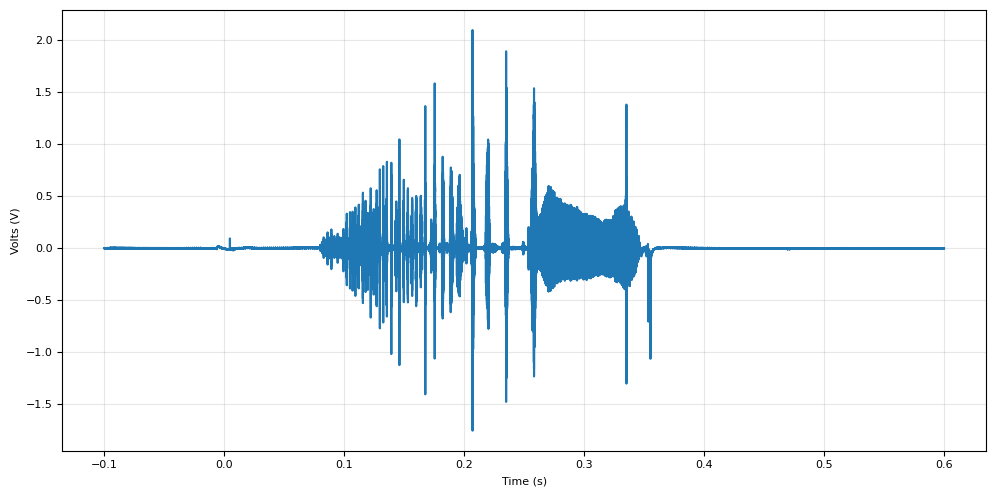

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(dataset['time'], dataset['omaha_3lz'])
ax.grid()

ax.grid(alpha=0.3)
ax.set_ylabel('Volts (V)')
ax.set_xlabel('Time (s)')

plt.tight_layout()

Looking at the spectrogram of the dataset can show us information about the MHD modes. Here we see several mode instabilities occuring before the plasma is lost.

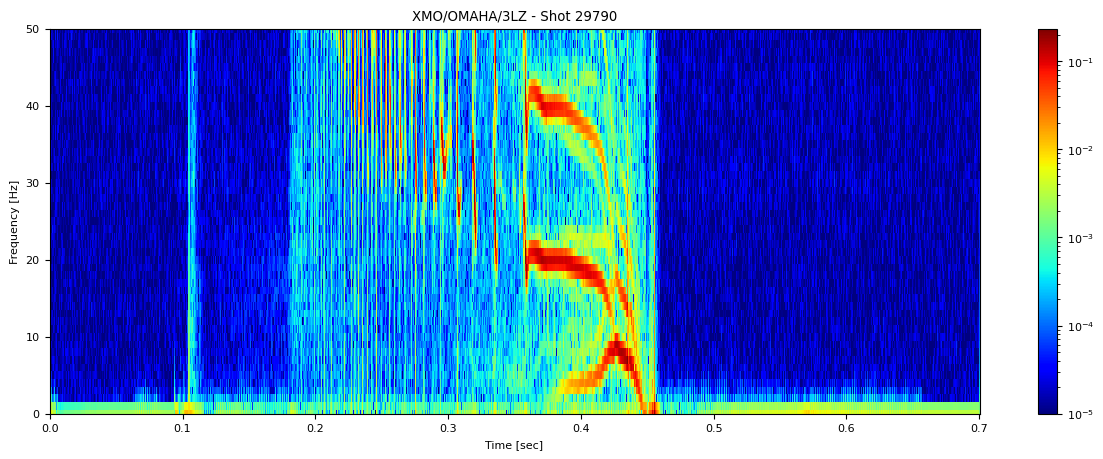

In [74]:
ds = dataset['omaha_3lz']
# Parameters to limit the number of frequencies
nperseg = 2000  # Number of points per segment
nfft = 2000  # Number of FFT points

# Compute the Short-Time Fourier Transform (STFT)
sample_rate = 1/(ds.time[1] - ds.time[0])
f, t, Zxx = stft(ds, fs=int(sample_rate), nperseg=nperseg, nfft=nfft)

fig, ax = plt.subplots(figsize=(15, 5))
cax = ax.pcolormesh(t, f/1000, np.abs(Zxx), shading='nearest', cmap='jet', norm=LogNorm(vmin=1e-5))
ax.set_ylim(0, 50)
ax.set_title(f'XMO/OMAHA/3LZ - Shot {ds.attrs["shot_id"]}')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [sec]')
plt.colorbar(cax, ax=ax)

## Photron Camera Data

### RBA

RBA contains the data from Photron bullet camera A. 

A Photron Bullet Camera provides high-speed, high-resolution imaging of fast transient events in the plasma. Its ability to capture detailed images of plasma instabilities, turbulence, and disruptions makes it essential for understanding and controlling plasma behavior, ultimately aiding in the pursuit of sustained nuclear fusion.

In [75]:
dataset = level1_catalog(urlpath=url, group='rba')
dataset = dataset.shots.read()
dataset

/opt/homebrew/anaconda3/lib/python3.12/site-packages/zarr/storage/_fsspec.py:195: UserWarning: fs (<fsspec.implementations.cached.SimpleCacheFileSystem object at 0x160096ff0>) was not created with `asynchronous=True`, this may lead to surprising behavior
  return cls(fs=fs, path=path, read_only=read_only, allowed_exceptions=allowed_exceptions)


<xarray.Dataset> Size: 130MB
Dimensions:  (time: 186, height: 912, width: 768)
Coordinates:
  * time     (time) float64 1kB 0.000256 0.002256 0.004256 ... 0.3093 0.3103
Dimensions without coordinates: height, width
Data variables:
    data     (time, height, width) uint8 130MB dask.array<chunksize=(186, 912, 768), meta=np.ndarray>
Attributes: (12/48)
    CLASS:           IMAGE
    IMAGE_SUBCLASS:  IMAGE_INDEXED
    IMAGE_VERSION:   1.2
    board_temp:      0.0
    bottom:          1024
    camera:          
    ...              ...
    units:           pixels
    uuid:            4a073a8f-aa2d-5deb-95df-91f93194c494
    vbin:            0
    version:         -1
    view:            Hl07 floor mount + FFC2 + 25mm lens + CII filter
    width:           768

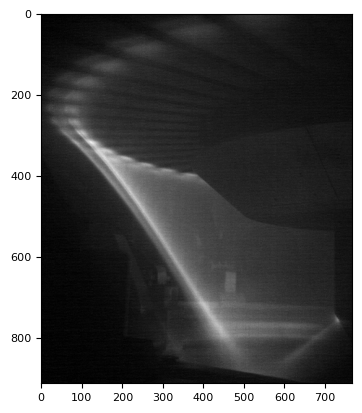

In [76]:
plt.imshow(dataset.data[-10], cmap='gray')

### RBB

RBB contains the data from Photron bullet camera B, which is looking at the central column. 

A Photron Bullet Camera provides high-speed, high-resolution imaging of fast transient events in the plasma. Its ability to capture detailed images of plasma instabilities, turbulence, and disruptions makes it essential for understanding and controlling plasma behavior, ultimately aiding in the pursuit of sustained nuclear fusion.

In [77]:
dataset = level1_catalog(urlpath=url, group='rbb')
dataset = dataset.shots.read()
dataset

/opt/homebrew/anaconda3/lib/python3.12/site-packages/zarr/storage/_fsspec.py:195: UserWarning: fs (<fsspec.implementations.cached.SimpleCacheFileSystem object at 0x1616f1040>) was not created with `asynchronous=True`, this may lead to surprising behavior
  return cls(fs=fs, path=path, read_only=read_only, allowed_exceptions=allowed_exceptions)


<xarray.Dataset> Size: 82MB
Dimensions:  (time: 286, height: 448, width: 640)
Coordinates:
  * time     (time) float64 2kB 1.6e-05 0.002016 0.004016 ... 0.308 0.309 0.31
Dimensions without coordinates: height, width
Data variables:
    data     (time, height, width) uint8 82MB dask.array<chunksize=(286, 448, 640), meta=np.ndarray>
Attributes: (12/48)
    CLASS:           IMAGE
    IMAGE_SUBCLASS:  IMAGE_INDEXED
    IMAGE_VERSION:   1.2
    board_temp:      0.0
    bottom:          680
    camera:          
    ...              ...
    units:           pixels
    uuid:            10ed506a-3ac4-5e62-8a6b-25a7abfc3171
    vbin:            0
    version:         -1
    view:            photron HM10 + Dalpha filter
    width:           640

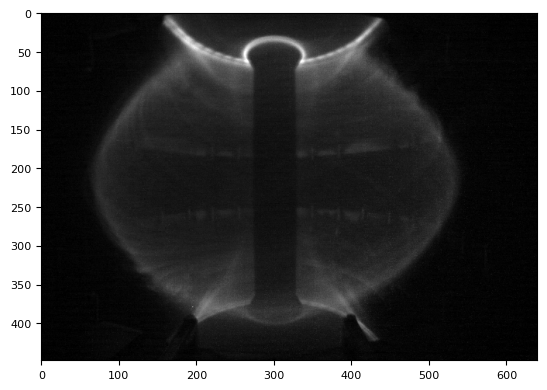

In [78]:
plt.imshow(dataset.data[-10], cmap='gray')